In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, GraphConv, GATv2Conv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tqdm.notebook import tqdm
import os
import seaborn as sns

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


Creating synthetic dataset...
Data shapes: X_train: (4000, 32, 32), y_train: (4000,)
             X_test: (1000, 32, 32), y_test: (1000,)


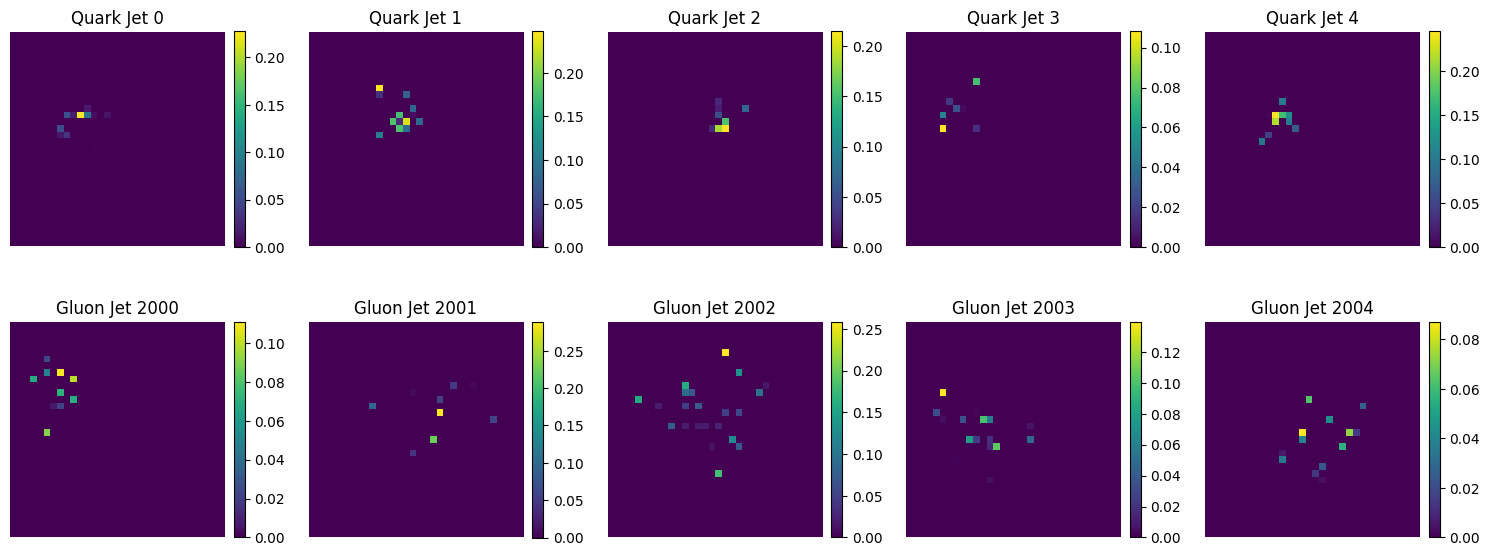

In [15]:
# Load the jet image dataset
# Assuming data is in numpy format with shapes:
# X_train: (n_samples, height, width) - jet images
# y_train: (n_samples,) - labels (0 for quark, 1 for gluon)

def load_data(data_path="./data"):
    """Load jet image dataset"""
    X_train = np.load(os.path.join(data_path, "X_train.npy"))
    y_train = np.load(os.path.join(data_path, "y_train.npy"))
    X_test = np.load(os.path.join(data_path, "X_test.npy"))
    y_test = np.load(os.path.join(data_path, "y_test.npy"))
    
    return X_train, y_train, X_test, y_test

# If you don't have the data, let's create a synthetic dataset
def create_synthetic_data(n_samples=10000, img_size=32, test_split=0.2):
    """Create synthetic jet data for demonstration"""
    # Create synthetic data
    # Quark jets tend to be more concentrated
    # Gluon jets tend to be more spread out
    
    n_train = int(n_samples * (1 - test_split))
    n_test = n_samples - n_train
    
    X_train = np.zeros((n_train, img_size, img_size))
    y_train = np.zeros(n_train)
    X_test = np.zeros((n_test, img_size, img_size))
    y_test = np.zeros(n_test)
    
    # Generate quark jets (more concentrated)
    for i in range(n_train // 2):
        # Random center of the jet
        cx, cy = np.random.randint(img_size//4, 3*img_size//4, 2)
        # Create a concentrated pattern
        for j in range(np.random.randint(5, 15)):  # Fewer particles
            dx, dy = np.random.normal(0, 2, 2)  # Smaller spread
            px, py = int(cx + dx), int(cy + dy)
            if 0 <= px < img_size and 0 <= py < img_size:
                X_train[i, px, py] = np.random.exponential(1.0)  # Energy deposit
        
        y_train[i] = 0  # Quark
    
    # Generate gluon jets (more spread out)
    for i in range(n_train // 2, n_train):
        # Random center of the jet
        cx, cy = np.random.randint(img_size//4, 3*img_size//4, 2)
        # Create a more spread out pattern
        for j in range(np.random.randint(10, 25)):  # More particles
            dx, dy = np.random.normal(0, 4, 2)  # Larger spread
            px, py = int(cx + dx), int(cy + dy)
            if 0 <= px < img_size and 0 <= py < img_size:
                X_train[i, px, py] = np.random.exponential(0.7)  # Energy deposit
        
        y_train[i] = 1  # Gluon
    
    # Generate test data in a similar way
    for i in range(n_test // 2):
        cx, cy = np.random.randint(img_size//4, 3*img_size//4, 2)
        for j in range(np.random.randint(5, 15)):
            dx, dy = np.random.normal(0, 2, 2)
            px, py = int(cx + dx), int(cy + dy)
            if 0 <= px < img_size and 0 <= py < img_size:
                X_test[i, px, py] = np.random.exponential(1.0)
        
        y_test[i] = 0  # Quark
    
    for i in range(n_test // 2, n_test):
        cx, cy = np.random.randint(img_size//4, 3*img_size//4, 2)
        for j in range(np.random.randint(10, 25)):
            dx, dy = np.random.normal(0, 4, 2)
            px, py = int(cx + dx), int(cy + dy)
            if 0 <= px < img_size and 0 <= py < img_size:
                X_test[i, px, py] = np.random.exponential(0.7)
        
        y_test[i] = 1  # Gluon
    
    # Normalize energy values
    X_train = X_train / np.max(X_train)
    X_test = X_test / np.max(X_test)
    
    return X_train, y_train, X_test, y_test

# Try to load data or create synthetic data
try:
    X_train, y_train, X_test, y_test = load_data()
    print("Loaded real dataset.")
except:
    print("Creating synthetic dataset...")
    X_train, y_train, X_test, y_test = create_synthetic_data(n_samples=5000, img_size=32)

print(f"Data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"             X_test: {X_test.shape}, y_test: {y_test.shape}")

# Visualize some examples
def plot_jet_examples(X, y, n_examples=5):
    """Plot example jet images"""
    quark_indices = np.where(y == 0)[0][:n_examples]
    gluon_indices = np.where(y == 1)[0][:n_examples]
    
    plt.figure(figsize=(15, 6))
    
    for i, idx in enumerate(quark_indices):
        plt.subplot(2, n_examples, i+1)
        plt.imshow(X[idx], cmap='viridis')
        plt.title(f"Quark Jet {idx}")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
    
    for i, idx in enumerate(gluon_indices):
        plt.subplot(2, n_examples, n_examples+i+1)
        plt.imshow(X[idx], cmap='viridis')
        plt.title(f"Gluon Jet {idx}")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot example images
plot_jet_examples(X_train, y_train)

Creating graphs:   0%|          | 0/4000 [00:00<?, ?it/s]

/var/folders/61/z36hrmy516l8jpg81wnm8pr00000gn/T/ipykernel_80676/3589935565.py:76: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  graph.y = torch.tensor([labels[i]], dtype=torch.long)  # Add label


Creating graphs:   0%|          | 0/1000 [00:00<?, ?it/s]

Created 4000 training graphs and 1000 testing graphs
Training Dataset Statistics:
  Number of graphs: 4000
  Nodes per graph: min=3, mean=12.4, max=24
  Edges per graph: min=6, mean=145.9, max=380


/Users/cassie/Documents/GSoC/.conda/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


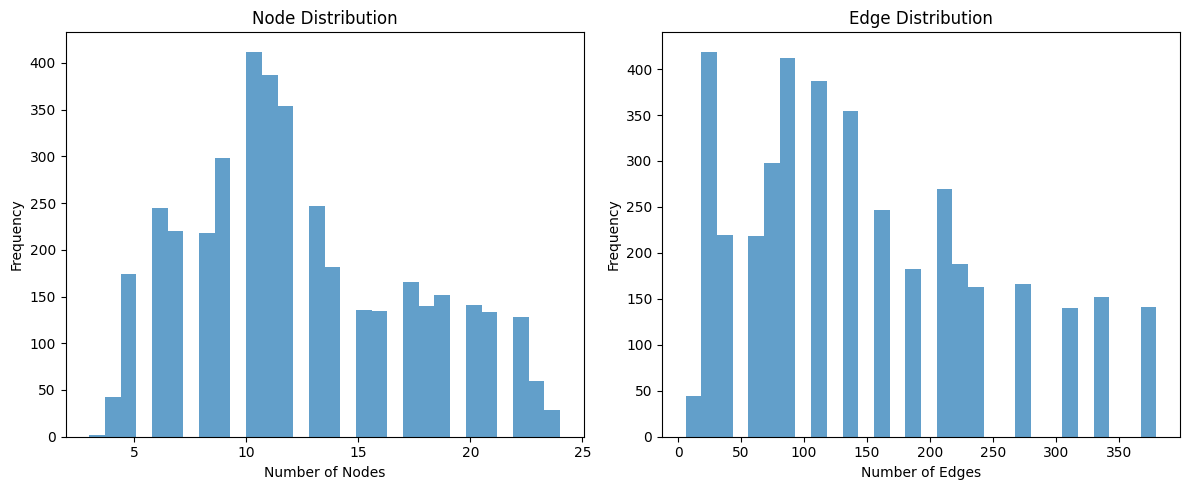

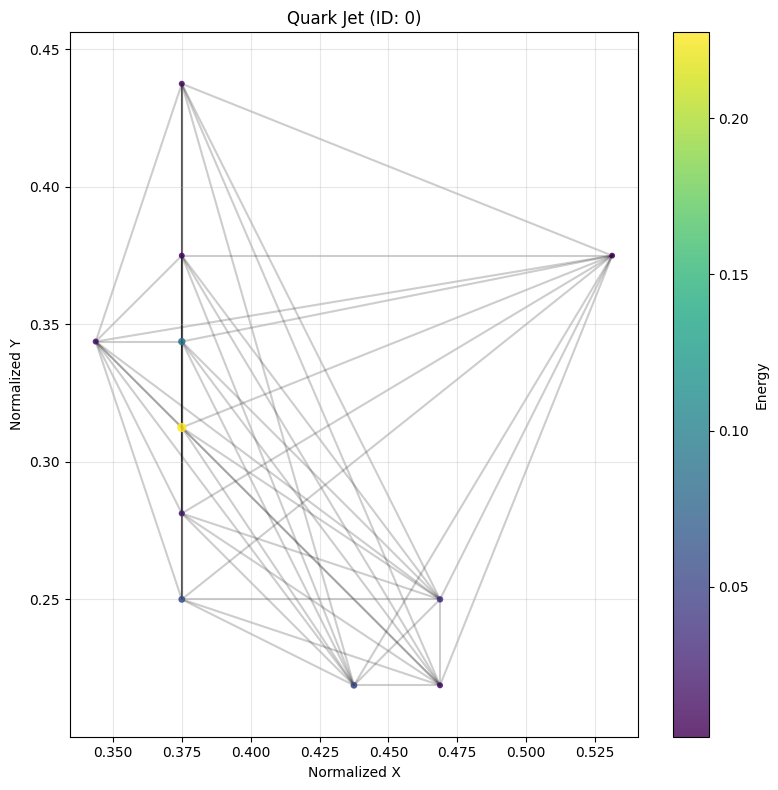

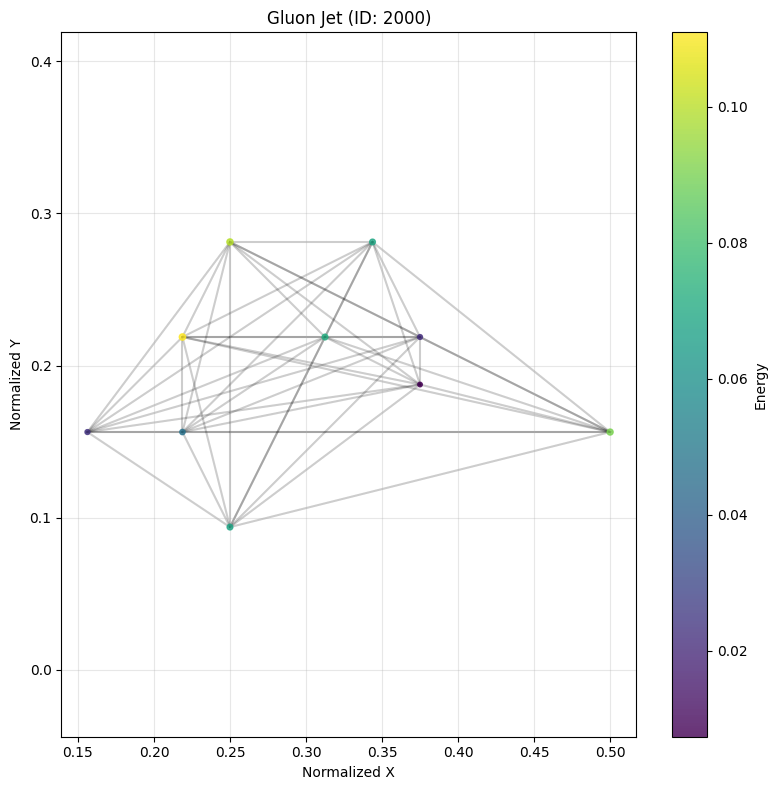

In [16]:
def image_to_graph(image):
    """
    Convert a jet image to a graph representation
    
    Args:
        image: 2D numpy array representing the jet image
        
    Returns:
        data: PyTorch Geometric Data object representing the graph
    """
    # Find non-zero pixels (active cells)
    non_zero_indices = np.where(image > 0)
    
    # Extract coordinates and features (energy values)
    coords = np.array(list(zip(non_zero_indices[0], non_zero_indices[1])))
    features = image[non_zero_indices].reshape(-1, 1)  # Energy as node feature
    
    # Skip empty images
    if len(coords) == 0:
        # Create a dummy graph with a single node
        coords = np.array([[0, 0]])
        features = np.array([[0.0]])
    
    # Calculate edge connections (k-nearest neighbors)
    # For simplicity, we'll connect all nodes to each other if less than 20 nodes
    # Otherwise, we'll compute a distance-based connection
    n_nodes = len(coords)
    
    if n_nodes <= 20:
        # Fully connected graph
        source, target = [], []
        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j:
                    source.append(i)
                    target.append(j)
    else:
        # Connect based on distance (k-nearest neighbors)
        k = 5  # Number of neighbors
        source, target = [], []
        
        for i in range(n_nodes):
            # Calculate distances from node i to all other nodes
            dist = np.sum((coords - coords[i])**2, axis=1)
            # Find k nearest neighbors (excluding itself)
            nearest = np.argsort(dist)[1:k+1]
            
            for j in nearest:
                source.append(i)
                target.append(j)
                # Make it bidirectional
                source.append(j)
                target.append(i)
    
    # Create edge index tensor
    edge_index = torch.tensor([source, target], dtype=torch.long)
    
    # Create node feature tensor
    # Add positional information to node features
    normalized_coords = coords / image.shape[0]  # Normalize to [0,1]
    node_features = np.hstack([features, normalized_coords])
    node_features = torch.tensor(node_features, dtype=torch.float)
    
    # Create PyTorch Geometric Data object
    data = Data(x=node_features, edge_index=edge_index)
    
    return data

# Convert training and testing datasets to graph format
def create_graph_dataset(images, labels):
    """Convert image dataset to graph dataset"""
    graph_dataset = []
    
    for i in tqdm(range(len(images)), desc="Creating graphs"):
        graph = image_to_graph(images[i])
        graph.y = torch.tensor([labels[i]], dtype=torch.long)  # Add label
        graph_dataset.append(graph)
    
    return graph_dataset

# Create graph datasets
train_dataset = create_graph_dataset(X_train, y_train)
test_dataset = create_graph_dataset(X_test, y_test)

print(f"Created {len(train_dataset)} training graphs and {len(test_dataset)} testing graphs")

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Analyze graph properties
def analyze_graph_dataset(dataset, name="Dataset"):
    """Analyze properties of graph dataset"""
    n_nodes = []
    n_edges = []
    
    for data in dataset:
        n_nodes.append(data.x.shape[0])
        n_edges.append(data.edge_index.shape[1])
    
    print(f"{name} Statistics:")
    print(f"  Number of graphs: {len(dataset)}")
    print(f"  Nodes per graph: min={min(n_nodes)}, mean={np.mean(n_nodes):.1f}, max={max(n_nodes)}")
    print(f"  Edges per graph: min={min(n_edges)}, mean={np.mean(n_edges):.1f}, max={max(n_edges)}")
    
    # Plot distributions
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(n_nodes, bins=30, alpha=0.7)
    plt.xlabel("Number of Nodes")
    plt.ylabel("Frequency")
    plt.title("Node Distribution")
    
    plt.subplot(1, 2, 2)
    plt.hist(n_edges, bins=30, alpha=0.7)
    plt.xlabel("Number of Edges")
    plt.ylabel("Frequency")
    plt.title("Edge Distribution")
    
    plt.tight_layout()
    plt.show()

# Analyze graph datasets
analyze_graph_dataset(train_dataset, "Training Dataset")

# Visualize a sample graph
def visualize_graph(data, title="Jet Graph"):
    """Visualize a graph representation of a jet"""
    # Extract node positions and features
    pos = data.x[:, 1:].numpy()  # Assuming x, y coordinates are in columns 1 and 2
    energies = data.x[:, 0].numpy()  # Energy in column 0
    edges = data.edge_index.numpy()
    
    plt.figure(figsize=(8, 8))
    
    # Plot edges
    for i in range(edges.shape[1]):
        src, dst = edges[0, i], edges[1, i]
        plt.plot([pos[src, 0], pos[dst, 0]], [pos[src, 1], pos[dst, 1]], 'k-', alpha=0.1, zorder=1)
    
    # Plot nodes
    scatter = plt.scatter(pos[:, 0], pos[:, 1], s=100*energies+10, c=energies, 
                         cmap='viridis', alpha=0.8, zorder=2)
    
    plt.colorbar(scatter, label='Energy')
    plt.title(title)
    plt.xlabel('Normalized X')
    plt.ylabel('Normalized Y')
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize some sample graphs
quark_idx = np.where(y_train == 0)[0][0]
gluon_idx = np.where(y_train == 1)[0][0]

visualize_graph(train_dataset[quark_idx], f"Quark Jet (ID: {quark_idx})")
visualize_graph(train_dataset[gluon_idx], f"Gluon Jet (ID: {gluon_idx})")

JetGNN(
  (conv1): GATv2Conv(3, 64, heads=4)
  (conv2): GATv2Conv(256, 128, heads=2)
  (conv3): GATv2Conv(256, 64, heads=1)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


/Users/cassie/Documents/GSoC/.conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 0.6930, Train Acc: 0.5072, Test Loss: 0.6930, Test Acc: 0.5000
Epoch 2/50, Train Loss: 0.6921, Train Acc: 0.5150, Test Loss: 0.6927, Test Acc: 0.5000
Epoch 3/50, Train Loss: 0.6911, Train Acc: 0.5302, Test Loss: 0.6932, Test Acc: 0.5000
Epoch 4/50, Train Loss: 0.6919, Train Acc: 0.5142, Test Loss: 0.6932, Test Acc: 0.5000
Epoch 5/50, Train Loss: 0.6910, Train Acc: 0.5198, Test Loss: 0.6928, Test Acc: 0.5000
Epoch 6/50, Train Loss: 0.6860, Train Acc: 0.5523, Test Loss: 0.6668, Test Acc: 0.6940
Epoch 7/50, Train Loss: 0.6307, Train Acc: 0.6390, Test Loss: 0.7695, Test Acc: 0.5710
Epoch 8/50, Train Loss: 0.5926, Train Acc: 0.6770, Test Loss: 0.7218, Test Acc: 0.6300
Epoch 9/50, Train Loss: 0.5668, Train Acc: 0.7017, Test Loss: 0.8116, Test Acc: 0.6160
Epoch 10/50, Train Loss: 0.5565, Train Acc: 0.7055, Test Loss: 0.6837, Test Acc: 0.6630
Epoch 11/50, Train Loss: 0.5655, Train Acc: 0.7105, Test Loss: 0.8402, Test Acc: 0.5760
Epoch 12/50, Train Loss: 0.5434, Train Ac

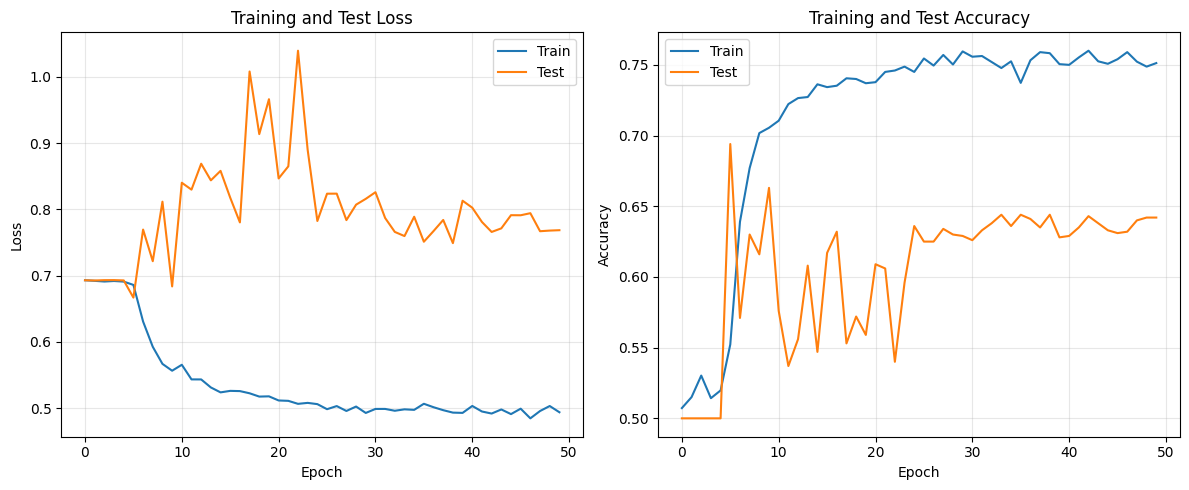

In [17]:
# Define the GNN model
class JetGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(JetGNN, self).__init__()
        
        # Graph convolutional layers
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=4)
        self.conv2 = GATv2Conv(hidden_channels * 4, hidden_channels * 2, heads=2)
        self.conv3 = GATv2Conv(hidden_channels * 4, hidden_channels, heads=1)
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, batch):
        # Graph convolution layers
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        
        # Graph-level pooling
        x = global_mean_pool(x, batch)
        
        # Classification layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Determine input feature dimensions
in_channels = train_dataset[0].x.shape[1]  # Features per node

# Create the model
hidden_channels = 64
out_channels = 2  # Binary classification (quark/gluon)
model = JetGNN(in_channels, hidden_channels, out_channels).to(device)
print(model)

# Define the training function
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
        total_loss += loss.item() * data.num_graphs
    
    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / total
    
    return avg_loss, accuracy

# Define the evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            
            # Calculate accuracy
            probs = F.softmax(out, dim=1)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
            total_loss += loss.item() * data.num_graphs
            
            # Save predictions and labels for ROC curve
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of being gluon
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / total
    
    return avg_loss, accuracy, all_preds, all_labels, all_probs

# Set up training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Train the model
n_epochs = 50
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    # Train
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_loss, test_acc, _, _, _ = evaluate(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Update learning rate
    scheduler.step(test_loss)
    
    # Print progress
    print(f"Epoch {epoch+1}/{n_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The Training did improve accuracy significantly, however, the huge gap between train and test accuracy indicate that the train-test split has space for improvement.Also, the test loss did not decline as expected, which further indicates this problem. This jet sorting model work much worse than the one in task2, so I think the problem might lie in the different form of original data given and my preprocessing.